In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Large
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score

<ipython-input-2-2cb6d5d07068>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Path dataset
train_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/train'
test_dir = '/content/drive/MyDrive/Univ/Semester 5/JST/CNN/test'

In [4]:
# Pengolahan data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)

Found 2278 images belonging to 3 classes.
Found 569 images belonging to 3 classes.


In [5]:
# Membangun model CNN menggunakan MobileNetV3 sebagai base model
def build_model(hp):
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner',
    project_name='emotion_classification'
)

12683000/12683000 [==============================] - 0s 0us/step


In [7]:
tuner.search(train_generator, epochs=10, validation_data=test_generator)

Trial 5 Complete [00h 06m 46s]
val_accuracy: 0.2671353220939636

Best val_accuracy So Far: 0.3743409514427185
Total elapsed time: 00h 41m 12s


In [8]:
# Ambil model terbaik dari pencarian tuner
best_model = tuner.get_best_models(1)[0]

In [9]:
# Memprediksi label kelas dari data uji
predictions = best_model.predict(test_generator)

18/18 [==============================] - 4s 168ms/step


In [10]:
# Mendapatkan kelas yang diprediksi untuk setiap sampel
predicted_classes = tf.argmax(predictions, axis=1)

In [11]:
# Mendapatkan label sebenarnya dari data uji
true_classes = test_generator.classes

In [12]:
# Evaluasi performa model
print("Accuracy:", accuracy_score(true_classes, predicted_classes))
print("Classification Report:\n", classification_report(true_classes, predicted_classes))

Accuracy: 0.37434094903339193
Classification Report:
               precision    recall  f1-score   support

           0       0.37      1.00      0.54       213
           1       0.00      0.00      0.00       207
           2       0.00      0.00      0.00       149

    accuracy                           0.37       569
   macro avg       0.12      0.33      0.18       569
weighted avg       0.14      0.37      0.20       569



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10
72/72 [==============================] - 57s 499ms/step - loss: 0.9869 - accuracy: 0.5329 - val_loss: 1.1793 - val_accuracy: 0.3743
Epoch 2/10
72/72 [==============================] - 34s 469ms/step - loss: 0.8483 - accuracy: 0.6168 - val_loss: 1.1797 - val_accuracy: 0.3743
Epoch 3/10
72/72 [==============================] - 34s 479ms/step - loss: 0.7415 - accuracy: 0.6870 - val_loss: 1.2036 - val_accuracy: 0.3743
Epoch 4/10
72/72 [==============================] - 35s 485ms/step - loss: 0.6366 - accuracy: 0.7327 - val_loss: 1.1877 - val_accuracy: 0.3743
Epoch 5/10
72/72 [==============================] - 35s 481ms/step - loss: 0.5697 - accuracy: 0.7704 - val_loss: 1.1704 - val_accuracy: 0.3761
Epoch 6/10
72/72 [==============================] - 35s 483ms/step - loss: 0.5199 - accuracy: 0.7888 - val_loss: 1.2237 - val_accuracy: 0.3743
Epoch 7/10
72/72 [==============================] - 37s 516ms/step - loss: 0.4670 - accuracy: 0.8205 - val_loss: 1.2256 - val_accuracy: 0.3743

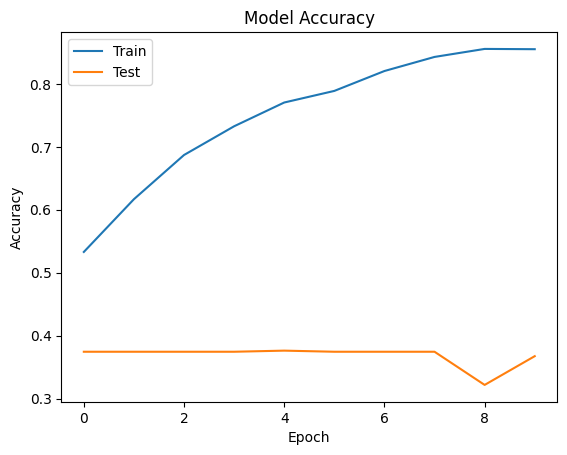

In [13]:
# Menampilkan grafik akurasi selama pelatihan model terbaik
history = best_model.fit(train_generator, epochs=10, validation_data=test_generator)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()